---

# Author Details

**Name:** Jahangir Hussen  
**Email:** jahangirhussen.programmer@gmai.com  
**Affiliation:** Sonargaon University  
**Date:** 22 September 2025  
**Project:** Multi-label Toxic Comment Classification using Machine Learning  
**Publication Status:** This research paper has been officially accepted by Sonargaon University for December 2025.  

**Execution Details:**  
- Accelerator: GPU P100  
- Runtime: 2 minutes 9 seconds


# Libraries Import & Dataset Loading


In [1]:
# Data handling
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# ML models & metrics
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Models
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier

# Load dataset
df = pd.read_csv('/kaggle/input/toxic-comment/toxic Data For SU .csv')

print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Shape: (159571, 7)
Columns: ['comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,!\n\nI won't stop! LOCK IT UP A$$HOLE,1,0,0,0,0,0
1,"!\n\nIt is now inside your bones, your head. H...",1,0,0,0,0,0
2,!\n\nSuck my DIHCK! Nihgga!\n\nYou don't want ...,1,1,1,0,1,0
3,!\n\nWHY DOESN'T ANYONE BAN ME \n\nBAN ME BAN ...,1,0,0,0,0,0
4,!\nPlease stop reverting my edits to Wesley Ho...,0,0,0,0,0,0


# Dataset Overview & Missing Values


In [2]:
# Dataset info
df.info()
df.describe()

# Missing values
print("Missing values:\n", df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   comment_text   159571 non-null  object
 1   toxic          159571 non-null  int64 
 2   severe_toxic   159571 non-null  int64 
 3   obscene        159571 non-null  int64 
 4   threat         159571 non-null  int64 
 5   insult         159571 non-null  int64 
 6   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 8.5+ MB
Missing values:
 comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64


# Label Distribution & Visualization

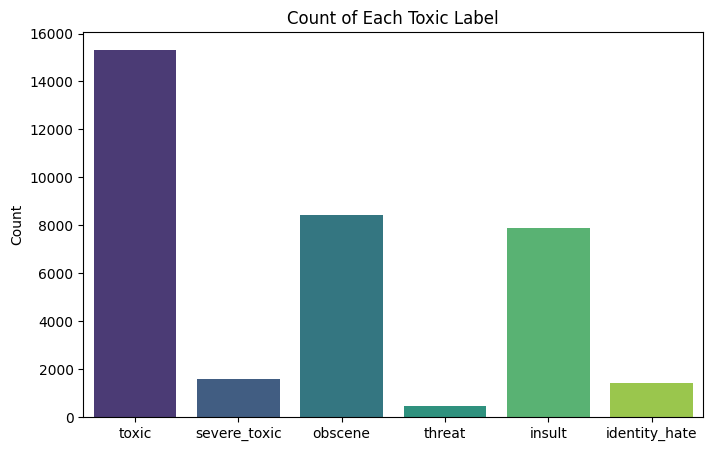

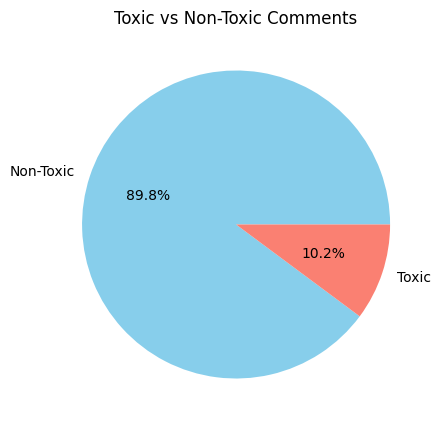

In [3]:
# Label distribution
label_cols = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
label_counts = df[label_cols].sum()

# Bar plot for label counts
plt.figure(figsize=(8,5))
sns.barplot(x=label_counts.index, y=label_counts.values, palette='viridis')
plt.title('Count of Each Toxic Label')
plt.ylabel('Count')
# Save bar plot to /kaggle/working/
plt.savefig('/kaggle/working/label_counts_barplot.png', dpi=300)
plt.show()

# Pie chart for toxic vs non-toxic
df['toxic_binary'] = (df[label_cols].sum(axis=1) > 0).astype(int)
plt.figure(figsize=(5,5))
df['toxic_binary'].value_counts().plot.pie(
    autopct='%1.1f%%', labels=['Non-Toxic','Toxic'], colors=['skyblue','salmon']
)
plt.title('Toxic vs Non-Toxic Comments')
plt.ylabel('')
# Save pie chart to /kaggle/working/
plt.savefig('/kaggle/working/toxic_vs_non_toxic.png', dpi=300)
plt.show()


# Text Preprocessing

In [4]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text).lower()
    text = re.sub('<.*?>', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub('[^a-zA-Z]', ' ', text)
    text = ' '.join(text.split())
    return text

def remove_stopwords(text):
    words = word_tokenize(text)
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['comment_text'] = df['comment_text'].fillna('')
df['comment_text'] = df['comment_text'].apply(clean_text)
df['comment_text'] = df['comment_text'].apply(remove_stopwords)
df['comment_text'] = df['comment_text'].apply(lambda x: ' '.join([lemmatizer.lemmatize(w) for w in x.split()]))


# Exploratory Data Analysis: Comment Length & Word Frequency


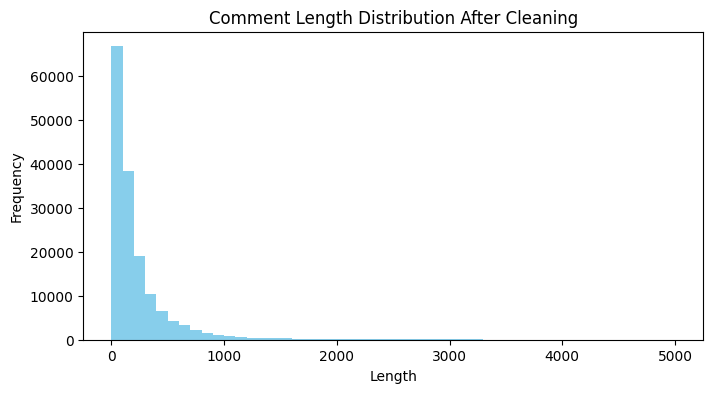

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


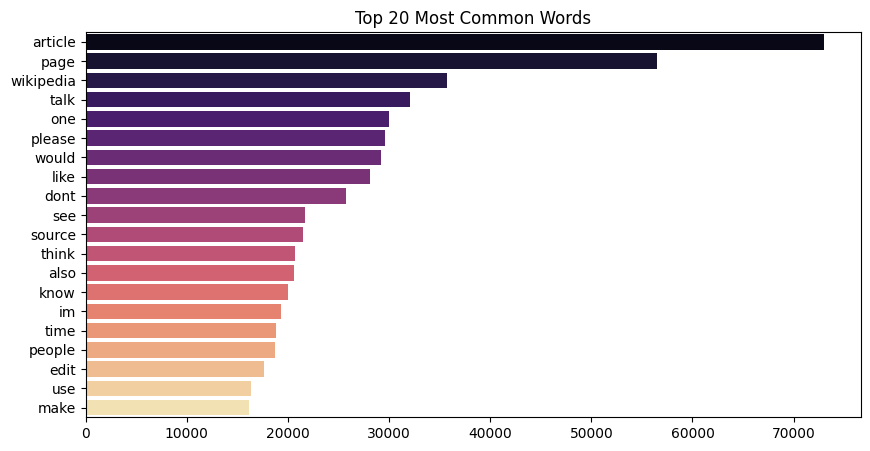

In [5]:
# Comment length histogram
plt.figure(figsize=(8,4))
plt.hist(df['comment_text'].apply(len), bins=50, color='skyblue')
plt.title('Comment Length Distribution After Cleaning')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.savefig('/kaggle/working/comment_length_distribution.png', dpi=300)
plt.show()

# Word frequency (optional visualization)
from collections import Counter

all_words = ' '.join(df['comment_text']).split()
most_common_words = Counter(all_words).most_common(20)
words, counts = zip(*most_common_words)

plt.figure(figsize=(10,5))
sns.barplot(x=list(counts), y=list(words), palette='magma')
plt.title('Top 20 Most Common Words')
# Save barplot
plt.savefig('/kaggle/working/most_common_words.png', dpi=300)
plt.show()


# Label Correlation Analysis

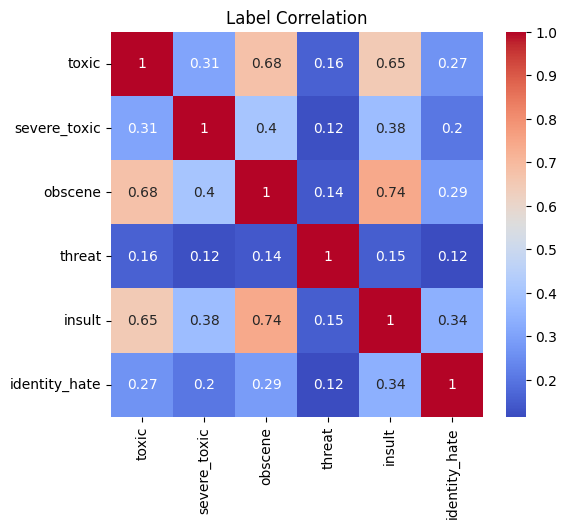

In [6]:
plt.figure(figsize=(6,5))
sns.heatmap(df[label_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Label Correlation')
plt.savefig('/kaggle/working/label_correlation_heatmap.png', dpi=300)

plt.show()


# Feature Extraction & Train-Test Split


In [7]:
tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, ngram_range=(1,2), stop_words='english')
X_tfidf = tfidf.fit_transform(df['comment_text'])
y = df[label_cols]

X_train, X_test, y_train, y_test = train_test_split(
    X_tfidf, y, test_size=0.2, random_state=42, stratify=df['toxic_binary']
)


# Model Initialization & Training


In [8]:
# 1. SVM
svm_model = OneVsRestClassifier(LinearSVC())

# 2. Logistic Regression
lr_model = OneVsRestClassifier(LogisticRegression(max_iter=1000))

# 3. Naive Bayes
nb_model = OneVsRestClassifier(MultinomialNB())

# Fit models
svm_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
nb_model.fit(X_train, y_train)

# Store models
models = {
    "SVM": svm_model,
    "Logistic Regression": lr_model,
    "Naive Bayes": nb_model,
}


# Model Evaluation & Accuracy Comparison


----- SVM -----
               Accuracy  Precision    Recall  F1-score
toxic          0.957825   0.862563  0.667319  0.752483
severe_toxic   0.989409   0.572414  0.231198  0.329365
obscene        0.978349   0.871332  0.690107  0.770203
threat         0.997838   0.702703  0.309524  0.429752
insult         0.970327   0.770105  0.562939  0.650425
identity_hate  0.991509   0.669643  0.242718  0.356295
----- Logistic Regression -----
               Accuracy  Precision    Recall  F1-score
toxic          0.953313   0.928727  0.556751  0.696166
severe_toxic   0.989284   0.597701  0.144847  0.233184
obscene        0.975309   0.917448  0.582837  0.712828
threat         0.997462   0.636364  0.083333  0.147368
insult         0.969481   0.829431  0.475399  0.604387
identity_hate  0.991164   0.728814  0.139159  0.233696
----- Naive Bayes -----
               Accuracy  Precision    Recall  F1-score
toxic          0.933323   0.963439  0.318004  0.478176
severe_toxic   0.988751   0.500000  0.005571  0.

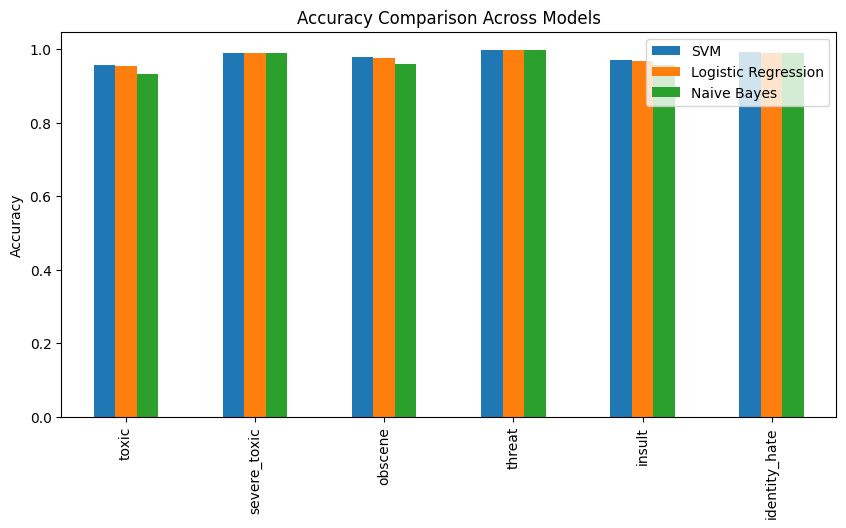

In [9]:
metrics_all = {}
for name, model in models.items():
    y_pred = model.predict(X_test)
    metrics_dict = {}
    for i, label in enumerate(label_cols):
        metrics_dict[label] = {
            'Accuracy': accuracy_score(y_test.iloc[:,i], y_pred[:,i]),
            'Precision': precision_score(y_test.iloc[:,i], y_pred[:,i]),
            'Recall': recall_score(y_test.iloc[:,i], y_pred[:,i]),
            'F1-score': f1_score(y_test.iloc[:,i], y_pred[:,i])
        }
    metrics_df = pd.DataFrame(metrics_dict).T
    metrics_all[name] = metrics_df
    print(f"----- {name} -----")
    print(metrics_df)

# Accuracy comparison graph
acc_df = pd.DataFrame({name: df['Accuracy'] for name, df in metrics_all.items()})
acc_df.plot(kind='bar', figsize=(10,5))
plt.title('Accuracy Comparison Across Models')
plt.ylabel('Accuracy')
plt.savefig('/kaggle/working/model_accuracy_comparison.png', dpi=300)

plt.show()


# Sample Comment Predictions


In [10]:
sample_comments = [
    "I hate you and your stupid face!",            
    "Thank you for your help, I really appreciate it.",
    "I will fuck you, also kill you idiot"
]

sample_features = tfidf.transform(sample_comments)

for name, model in models.items():
    print(f"----- {name} Predictions -----")
    pred_labels = model.predict(sample_features)
    for i, comment in enumerate(sample_comments):
        print(f"Comment: {comment}")
        print("Predicted Labels:")
        for j, label in enumerate(label_cols):
            print(f"  {label}: {pred_labels[i,j]}")
        print("-----")


----- SVM Predictions -----
Comment: I hate you and your stupid face!
Predicted Labels:
  toxic: 1
  severe_toxic: 0
  obscene: 1
  threat: 0
  insult: 1
  identity_hate: 0
-----
Comment: Thank you for your help, I really appreciate it.
Predicted Labels:
  toxic: 0
  severe_toxic: 0
  obscene: 0
  threat: 0
  insult: 0
  identity_hate: 0
-----
Comment: I will fuck you, also kill you idiot
Predicted Labels:
  toxic: 1
  severe_toxic: 0
  obscene: 1
  threat: 0
  insult: 1
  identity_hate: 0
-----
----- Logistic Regression Predictions -----
Comment: I hate you and your stupid face!
Predicted Labels:
  toxic: 1
  severe_toxic: 0
  obscene: 1
  threat: 0
  insult: 1
  identity_hate: 0
-----
Comment: Thank you for your help, I really appreciate it.
Predicted Labels:
  toxic: 0
  severe_toxic: 0
  obscene: 0
  threat: 0
  insult: 0
  identity_hate: 0
-----
Comment: I will fuck you, also kill you idiot
Predicted Labels:
  toxic: 1
  severe_toxic: 1
  obscene: 1
  threat: 1
  insult: 1
  ident

---

# Author Details

**Name:** Jahangir Hussen  
**Email:** jahangirhussen.programmer@gmai.com  
**Affiliation:** Sonargaon University  
**Date:** 22 September 2025  
**Project:** Multi-label Toxic Comment Classification using Machine Learning  
**Publication Status:** This research paper has been officially accepted by Sonargaon University for December 2025.
